In [7]:
import requests
import json
from lxml import html
from ncbiumls.authorization import authorization
from time import sleep
import matplotlib.pyplot as plt
%matplotlib inline


class UMLS(authorization):
    def __init__(self, api_key='e9990d5d-ff93-40f1-9f60-29ce7cf2950c'):
        super().__init__(str(api_key))

    def askTerm(self, term, inputType='atom', includeObsolete='false', includeSuppressible='false',
                returnIdType='concept', searchType='words', pageNumber=1, pageSize=25):

#   TODO: Add option like dump, if enabled - save data, current page, page size
#   TODO: Write some messages on succesfull access, like pageNumber etc.

        """
        Description: retrives all records associted with the term, returns list of dicts,
                     each dict have keywords name,uri,ui,rootSource.


        :param term:                A human readable term, such as 'gestatational diabetes', or a code from a source
                                    vocabulary, such as 11687002 from SNOMEDCT_US.

        :param inputType:           Specifies the data type you are using as your search parameter.
                                    Valid values:  'atom', 'code','sourceConcept','sourceDescriptor','sourceUi','tty'
                                    Default value: 'atom'
                                    Usage Note:     Use 'sourceUi' if you aren't sure if the identifier you're providing
                                                    is a code, source concept, or source descriptor. Using 'tty' is for
                                                    advanced use cases and will extract codes from a specified
                                                    vocabulary according to term type.

        :param includeObsolete:     Return content that is a result of matches on obsolete terms.
                                    Valid values:   true or false
                                    Default value: 'false'

        :param includeSuppressible: Return content that is a result of matches on suppressible terms.
                                    Valid values:   true or false
                                    Default value: 'false'

        :param returnIdType:        Specifies the type of identifier you wish to retrieve.
                                    Valid values:   true or false
                                    Default value: 'false'
                                    Usage Note:     Use 'code','sourceConcept', 'sourceDescriptor', or 'sourceUi' if you
                                                    prefer source-asserted identifiers rather than CUIs in your search
                                                    results.

        :param searchType:          Type of search you wish to use.
                                    Valid values:  'exact','words','leftTruncation', 'rightTruncation','approximate',
                                                   'normalizedString'
                                    Default value: 'words'
                                    Usage Note:     Use 'exact' when using inputType = 'code', 'sourceConcept',
                                                   'sourceDescriptor', or 'sourceUi'.

        :param pageNumber:          Whole number that specifies which page of results to fetch
                                    Valid values:   1,2,3, etc
                                    Default value:  1

        :param pageSize:            Whole number that specifies the number of results to include per page.
                                    Valid values:   1,2,3, etc
                                    Default value:  25

        :return:
        """
        # main url and parameters
        url = 'https://uts-ws.nlm.nih.gov/rest/search/current'
        params = {'ticket': '',
                  'string': str(term),
                  'inputType': inputType,
                  'includeObsolete': includeObsolete,
                  'includeSuppressible': includeSuppressible,
                  'returnIdType': returnIdType,
                  'searchType': searchType,
                  'pageNumber': pageNumber,
                  'pageSize': pageSize}

        #varible to store received data
        data = []

        #in case specific page is not provided - grab all results starting from page 1
        if pageNumber == 1:

            #function is guaranteed to return results so ask cycle will roll infinitely
            while True:

                #get a service ticket
                params['ticket'] = self.getST()

                #access page
                get = requests.get(url=url, params=params)
                try:

                    #if all the results obtained return gathered data
                    if get.json()['result'] == {'results': [{'ui': 'NONE', 'name': 'NO RESULTS'}],
                                                  'classType': 'searchResults'}:
                        return data

                    #else grab some more data
                    else:
                        for item in get.json()['result']['results']:
                            data.append(item)
                        params['pageNumber'] += 1

                #if server returned error - try to print that error, wait and retry request
                except Exception as exp:
                    response = html.fromstring(data.text)
                    print(response.xpath('.//p/b[contains(text(),"description")]/following::u')[0].text,
                          ', current page number = ' + str(pageNumber),
                          ', current page size = ' + str(pageSize))

                #to not overlode server pause a bit
                sleep(0.5)

        #else access specific page
        else:
            params['ticket'] = self.getST()
            get = requests.get(url=url, params=params)
            try:
                return get.json()['result']['results']
            except Exception as exp:
                response = html.fromstring(data.text)
                print(response.xpath('.//p/b[contains(text(),"description")]/following::u')[0].text,
                      ', current page number = ' + str(pageNumber),
                      ', current page size = ' + str(pageSize))



class CUI(authorization):
    def __init__(self, api_key='e9990d5d-ff93-40f1-9f60-29ce7cf2950c'):
        super().__init__(api_key=api_key)

    def CUIGeneral(self, cui):
        """
        :param cui: The Concept Unique Identifier for a Metathesaurus concept
        :return: Returns dictionary processed from JSON, example:
                {
                    "pageSize": 25,
                    "pageNumber": 1,
                    "pageCount": 1,
                    "result": {
                        "classType": "Concept",
                        "ui": "C0009044",
                        "suppressible": false,
                        "dateAdded": "09-30-1990",
                        "majorRevisionDate": "08-18-2015",
                        "status": "R",
                        "semanticTypes": [
                            {
                                "name": "Injury or Poisoning",
                                "uri": "https://uts-ws.nlm.nih.gov/rest/semantic-network/2015AB/TUI/T037"
                            }
                        ],
                        "atomCount": 63,
                        "attributeCount": 0,
                        "cvMemberCount": 0,
                        "atoms": "https://uts-ws.nlm.nih.gov/rest/content/2015AB/CUI/C0009044/atoms",
                        "definitions": "NONE",
                        "relations": "https://uts-ws.nlm.nih.gov/rest/content/2015AB/CUI/C0009044/relations",
                        "defaultPreferredAtom": "https://uts-ws.nlm.nih.gov/rest/content/
                                                        2015AB/CUI/C0009044/atoms/preferred",
                        "relationCount": 5,
                        "name": "Closed fracture carpal bone"
                    }
                }
        """
        stTicket = self.getST()
        url = 'https://uts-ws.nlm.nih.gov/rest/content/current/CUI/' + str(cui)
        params = {'ticket': stTicket}
        data = requests.get(url=url, params=params)
        try:
            return data.json()

        except Exception as exp:
            response = html.fromstring(data.text)
            return response.xpath('.//p/b[text()="message"]/u')

    def CUISemanticTypes(self, cui):
        """
        :param cui: The Concept Unique Identifier for a Metathesaurus concept
        :return: Returns dictionary processed from JSON, example:
                {
                    "pageSize": 25,
                    "pageNumber": 1,
                    "pageCount": 1,
                    "result": {
                        "classType": "Concept",
                        "ui": "C0009044",
                        "suppressible": false,
                        "dateAdded": "09-30-1990",
                        "majorRevisionDate": "08-18-2015",
                        "status": "R",
                        "semanticTypes": [
                            {
                                "name": "Injury or Poisoning",
                                "uri": "https://uts-ws.nlm.nih.gov/rest/semantic-network/2015AB/TUI/T037"
                            }
                        ],
                        "atomCount": 63,
                        "attributeCount": 0,
                        "cvMemberCount": 0,
                        "atoms": "https://uts-ws.nlm.nih.gov/rest/content/2015AB/CUI/C0009044/atoms",
                        "definitions": "NONE",
                        "relations": "https://uts-ws.nlm.nih.gov/rest/content/2015AB/CUI/C0009044/relations",
                        "defaultPreferredAtom": "https://uts-ws.nlm.nih.gov/rest/content/
                                                        2015AB/CUI/C0009044/atoms/preferred",
                        "relationCount": 5,
                        "name": "Closed fracture carpal bone"
                    }
                }
        """
        stTicket = self.getST()
        url = 'https://uts-ws.nlm.nih.gov/rest/content/current/CUI/' + str(cui)
        params = {'ticket': stTicket}
        data = requests.get(url=url, params=params)
        try:
            return data.json()['result']['semanticTypes']

        except Exception as exp:
            response = html.fromstring(data.text)
            return response.xpath('.//p/b[text()="message"]/u')

    def CUIAtoms(self, cui, pageNumber=1, pageSize=25):
        stTicket = self.getST()
        url = 'https://uts-ws.nlm.nih.gov/rest/content/current/CUI/' + str(cui) + '/atoms'
        params = {'ticket': stTicket,
                  'pageNumber': pageNumber,
                  'pageSize': pageSize}
        data = requests.get(url=url, params=params)
        pass

    def CUIDefenitions(self, cui, pageNumber=1, pageSize=25):
        stTicket = self.getST()
        url = 'https://uts-ws.nlm.nih.gov/rest/content/current/CUI/' + str(cui) + '/definitions'
        params = {'ticket': stTicket,
                  'pageNumber': pageNumber,
                  'pageSize': pageSize}
        data = requests.get(url=url, params=params)
        pass

    def CUIRelations(self, cui, pageNumber=1, pageSize=25):
        stTicket = self.getST()
        url = 'https://uts-ws.nlm.nih.gov/rest/content/current/CUI/' + str(cui) + '/relations'
        params = {'ticket': stTicket,
                  'pageNumber': pageNumber,
                  'pageSize': pageSize}
        data = requests.get(url=url, params=params)
        pass

In [8]:
def get_sorted(p_dict):
    return sorted(p_dict.items(), key=lambda x: x[1], reverse=True)

In [17]:
import os

data = {}

for i in os.listdir('json/'):
    print(i)
    year = int(i.split('.')[0])
    with open('json/{}'.format(i)) as data_file:
        data[year] = json.load(data_file)
#         for ttype in ['chemicals', 'mesh_titles']:
#             for key, val in data[year][ttype].items():
#                 data[year][ttype][key] = val/data[year]['count_articles']

1990.json
1991.json
1992.json
1993.json
1994.json
1995.json
1996.json
1997.json
1998.json
1999.json
2000.json
2001.json
2002.json
2003.json
2004.json
2005.json
2006.json
2007.json
2008.json
2009.json
2010.json
2011.json
2012.json
2013.json
2014.json
2015.json
2016.json
2017.json


In [113]:
with open('top100_mt.txt', 'w') as f:
    f.write('\n'.join(list(map(lambda x: x[0], get_sorted(data[2009]['mesh_titles'])[:100]))))

In [114]:
with open('top100_chem.txt', 'w') as f:
    f.write('\n'.join(list(map(lambda x: x[0], get_sorted(data[2009]['chemicals'])[:100]))))

In [10]:
top100_mt = list(map(lambda x: x[0], get_sorted(data[2009]['mesh_titles'])[:100]))
top200_chem = list(map(lambda x: x[0], get_sorted(data[2009]['chemicals'])[:200]))

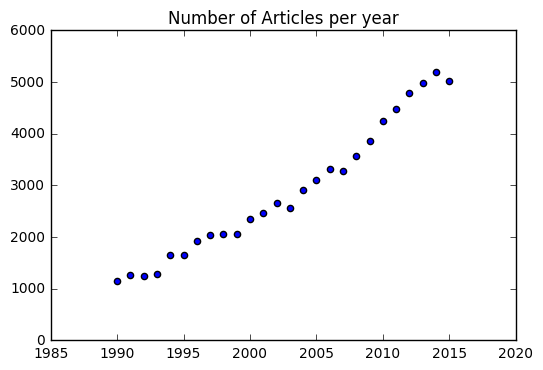

In [11]:
to_draw = []
inxs = []

for i in range(1990, 2016):
    if i in data:
        tmp = data[i]['count_articles']
        to_draw.append(tmp)
        inxs.append(i)
        
plt.figure()
plt.scatter(inxs, to_draw)
plt.title('Number of Articles per year')

In [52]:
def draw_plot(term, save=''):
    to_draw = []
    inxs = []

    for i in range(1990, 2016):
        if i in data and term in data[i]['chemicals']:
            tmp = data[i]['chemicals'][term]
            to_draw.append(tmp)
            inxs.append(i)

    plt.figure()
    plt.title(term)
    plt.scatter(inxs, to_draw)
    if save != '':
        plt.savefig(save)

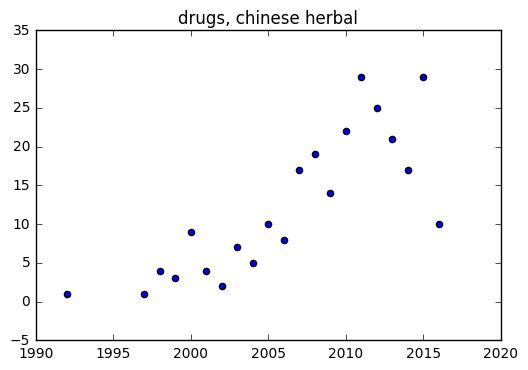

In [19]:
draw_plot('drugs, chinese herbal', 'ch_herbal.png')

In [20]:
import pandas as pd

df = pd.read_csv('output_cleaned.csv', sep=';', header=None)
df = df.dropna()
df

,0,1,2,3
0,1990.0,amyloid beta-protein precursor,0.054783,"['Amino Acid, Peptide, or Protein']"
1,1990.0,tacrine,0.017391,-
2,1990.0,acetylcholinesterase,0.016522,"['Amino Acid, Peptide, or Protein', 'Enzyme', ..."
3,1990.0,aluminum,0.015652,-
4,1990.0,physostigmine,0.010435,-
5,1990.0,hydrocortisone,0.009565,-
6,1990.0,acetylcholine,0.009565,"['Organic Chemical', 'Biologically Active Subs..."
7,1990.0,dopamine,0.007826,-
8,1990.0,hydroxyindoleacetic acid,0.007826,-
9,1990.0,choline,0.006957,-


In [80]:
tmpdf = df.groupby(0).head(12)
dict_of_topn = {}
for y,inst in zip(tmpdf.reset_index(drop=True)[0].values, tmpdf.reset_index(drop=True)[1].values):
    if int(y) not in dict_of_topn:
        dict_of_topn[int(y)] = []
    dict_of_topn[int(y)].append(inst)

In [81]:
for y in [1990, 2000, 2010, 2015]:
    print("Year: {}".format(y))
    print('-----')
    for inst in dict_of_topn[y]:
        print(inst)
    print('########')
    print()

Year: 1990
-----
amyloid beta-protein precursor
tacrine
acetylcholinesterase
aluminum
physostigmine
hydrocortisone
acetylcholine
dopamine
hydroxyindoleacetic acid
choline
immune sera
glutamic acid
########

Year: 2000
-----
amyloid beta-protein precursor
presenilin-1
psen1 protein, human
apolipoprotein e4
amyloid beta-protein (1-42)
presenilin-2
psen2 protein, human
bace1 protein, human
donepezil
amyloid beta-protein (1-40)
acetylcholine
acetylcholinesterase
########

Year: 2010
-----
amyloid beta-protein precursor
amyloid beta-protein (1-42)
apolipoprotein e4
presenilin-1
amyloid beta-protein (1-40)
donepezil
mapt protein, human
psen1 protein, human
cholesterol
fluorodeoxyglucose f18
bace1 protein, human
calcium
########

Year: 2015
-----
amyloid beta-protein precursor
amyloid beta-protein (1-42)
presenilin-1
apolipoprotein e4
psen1 protein, human
amyloid beta-protein (1-40)
app protein, human
mapt protein, human
fluorodeoxyglucose f18
acetylcholinesterase
donepezil
glucose
########



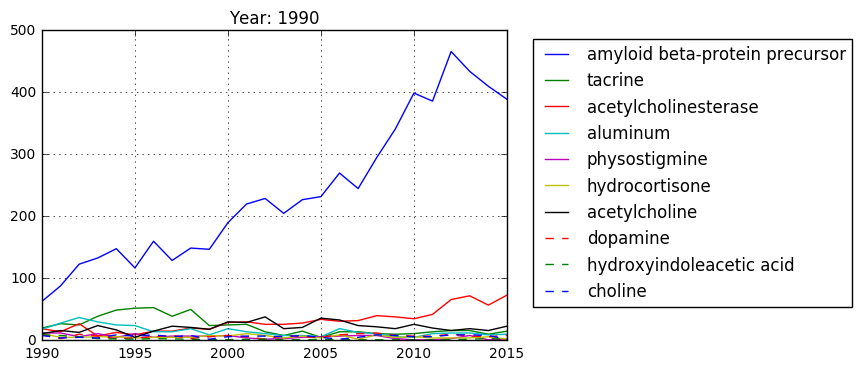

In [137]:
y = 1990

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'r--', 'g--', 'b--']
c = 0

for inst in dict_of_topn[y][:10]:
#     if inst == 'amyloid beta-protein (1-40)':
#         to_draw = []
#         inxs = []
#         term1 = 'presenilin-1'
#         term2 = 'psen1 protein, human'

#         for i in range(1990, 2016):
#             if i in data and term1 in data[i]['chemicals'] and term2 in data[i]['chemicals']:
#                 tmp = data[i]['chemicals'][term1] + data[i]['chemicals'][term2]
#                 to_draw.append(tmp)
#                 inxs.append(i)

#         ax.plot(inxs, to_draw, colors[c], label='presenilin-1')
#         c += 1
#     if inst in ['presenilin-2','psen2 protein, human','presenilin-1','psen1 protein, human']:
#         continue
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    to_draw = []
    inxs = []
    for i in range(1990, 2016):
        if i in data and inst in data[i]['chemicals']:
            tmp = data[i]['chemicals'][inst]
            to_draw.append(tmp)
            inxs.append(i)
            
    ax.plot(inxs, to_draw, colors[c], label=inst)
    c += 1

        
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.4,1))
    
ax.grid('on')    
plt.title("Year: {}".format(y))
fig.savefig('year{}'.format(y), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [ ]:
for y in [1990, 2000, 2010, 2015]:
    fig = plt.figure(1)
    for n,inst in enumerate(dict_of_topn[y]):
        ax = fig.add_subplot(111)
        
        to_draw = []
        inxs = []
        
        print(y, inst)
        for i in range(1990, 2016):
            if i in data and inst in data[i]['chemicals']:
                tmp = data[i]['chemicals'][inst]
                to_draw.append(tmp)
                inxs.append(i)
        ax.plot(inxs, to_draw, label=inst)
        
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.4,1))
    
    ax.grid('on')    
    plt.title("Year: {}".format(y))
    plt.show()

1990 amyloid beta-protein precursor
1990 tacrine
1990 acetylcholinesterase
1990 aluminum
1990 physostigmine
1990 hydrocortisone
1990 acetylcholine
1990 dopamine
1990 hydroxyindoleacetic acid
1990 choline
1990 immune sera
1990 glutamic acid


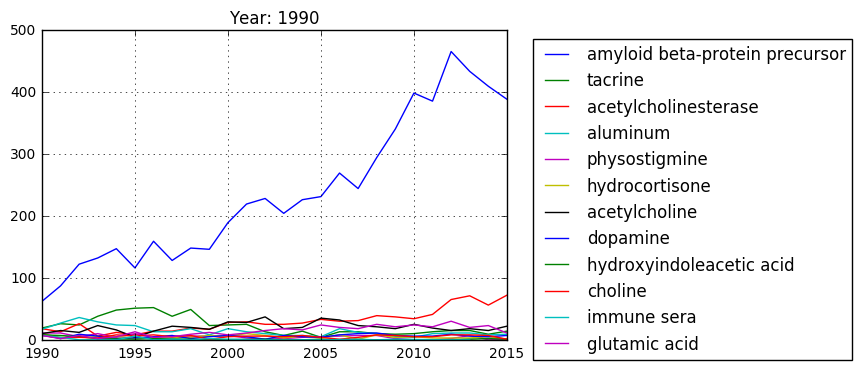

2000 amyloid beta-protein precursor
2000 presenilin-1
2000 psen1 protein, human
2000 apolipoprotein e4
2000 amyloid beta-protein (1-42)
2000 presenilin-2
2000 psen2 protein, human
2000 bace1 protein, human
2000 donepezil
2000 amyloid beta-protein (1-40)
2000 acetylcholine
2000 acetylcholinesterase


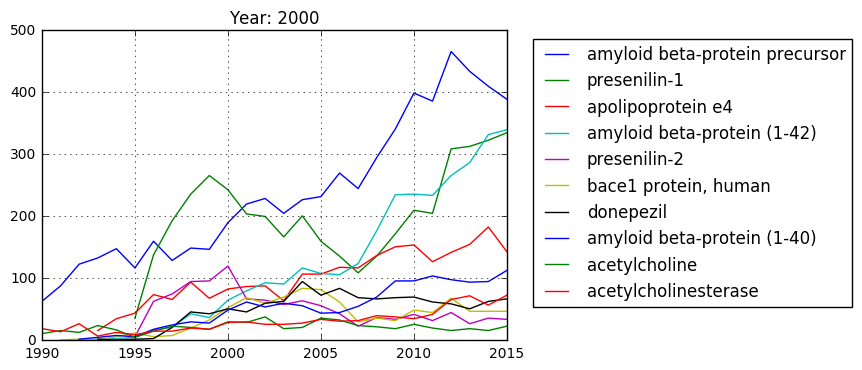

2010 amyloid beta-protein precursor
2010 amyloid beta-protein (1-42)
2010 apolipoprotein e4
2010 presenilin-1
2010 amyloid beta-protein (1-40)
2010 donepezil
2010 mapt protein, human
2010 psen1 protein, human
2010 cholesterol
2010 fluorodeoxyglucose f18
2010 bace1 protein, human
2010 calcium


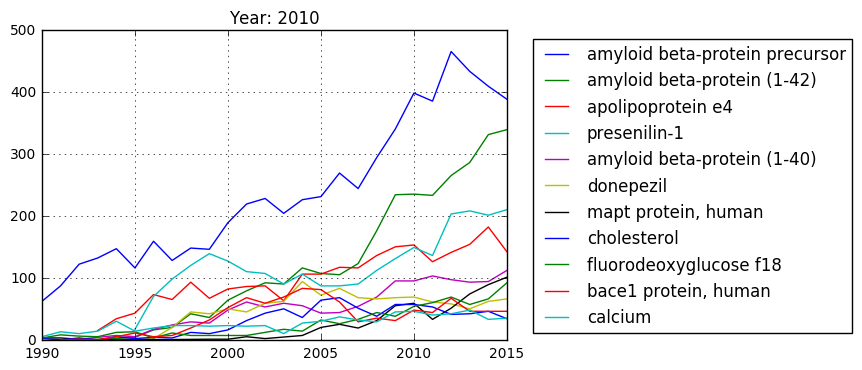

2015 amyloid beta-protein precursor
2015 amyloid beta-protein (1-42)
2015 presenilin-1
2015 apolipoprotein e4
2015 psen1 protein, human
2015 amyloid beta-protein (1-40)
2015 app protein, human
2015 mapt protein, human
2015 fluorodeoxyglucose f18
2015 acetylcholinesterase
2015 donepezil
2015 glucose


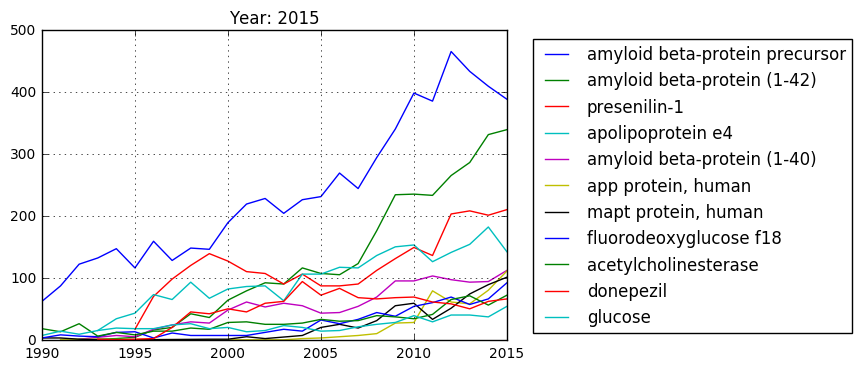

In [99]:
for y in [1990, 2000, 2010, 2015]:
    fig = plt.figure(1)
    for inst in dict_of_topn[y]:
        ax = fig.add_subplot(111)
        
        to_draw = []
        inxs = []
        
        print(y, inst)
        if y == 2000 and inst == 'presenilin-2':
            term1 = 'presenilin-2'
            term2 = 'psen2 protein, human'
            for i in range(1990, 2016):
                if i in data and term1 in data[i]['chemicals'] and term2 in data[i]['chemicals']:
                    tmp = data[i]['chemicals'][term1] + data[i]['chemicals'][term2]
                    to_draw.append(tmp)
                    inxs.append(i)
            ax.plot(inxs, to_draw, label=term1)
        elif y == 2000 and inst == 'presenilin-1':
            term1 = 'presenilin-1'
            term2 = 'psen1 protein, human'
            for i in range(1990, 2016):
                if i in data and term1 in data[i]['chemicals'] and term2 in data[i]['chemicals']:
                    tmp = data[i]['chemicals'][term1] + data[i]['chemicals'][term2]
                    to_draw.append(tmp)
                    inxs.append(i)
            ax.plot(inxs, to_draw, label=term1)
        elif inst in ['psen2 protein, human', 'psen1 protein, human']:
            continue
        else:
            for i in range(1990, 2016):
                if i in data and inst in data[i]['chemicals']:
                    tmp = data[i]['chemicals'][inst]
                    to_draw.append(tmp)
                    inxs.append(i)
            ax.plot(inxs, to_draw, label=inst)
        
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.4,1))
    
    ax.grid('on')    
    plt.title("Year: {}".format(y))
#     fig.savefig('year{}'.format(y), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

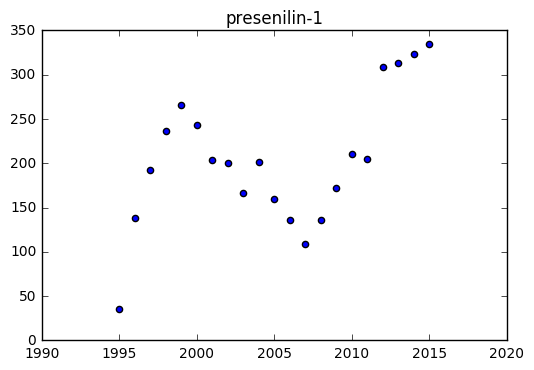

In [58]:
# PRESENILIN

to_draw = []
inxs = []
term1 = 'presenilin-1'
term2 = 'psen1 protein, human'

for i in range(1990, 2016):
    if i in data and term1 in data[i]['chemicals'] and term2 in data[i]['chemicals']:
        tmp = data[i]['chemicals'][term1] + data[i]['chemicals'][term2]
        to_draw.append(tmp)
        inxs.append(i)

plt.figure()
plt.title(term1)
plt.scatter(inxs, to_draw)
plt.savefig(term1)

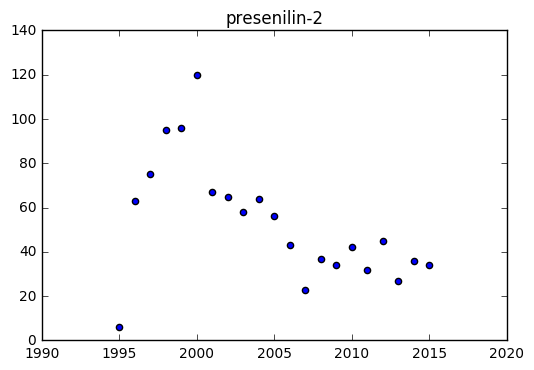

In [59]:
# PRESENILIN

to_draw = []
inxs = []
term1 = 'presenilin-2'
term2 = 'psen2 protein, human'

for i in range(1990, 2016):
    if i in data and term1 in data[i]['chemicals'] and term2 in data[i]['chemicals']:
        tmp = data[i]['chemicals'][term1] + data[i]['chemicals'][term2]
        to_draw.append(tmp)
        inxs.append(i)

plt.figure()
plt.title(term1)
plt.scatter(inxs, to_draw)
plt.savefig(term1)

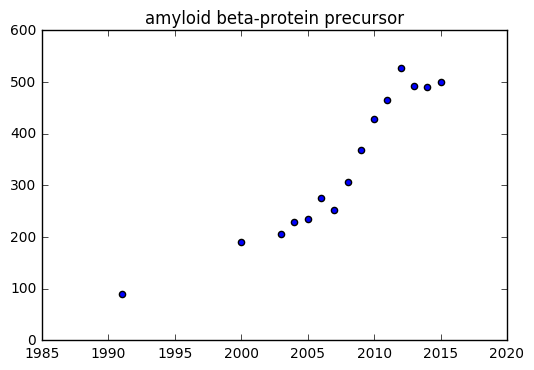

In [60]:
# PRESENILIN

to_draw = []
inxs = []
term1 = 'app protein, human'
term2 = 'amyloid beta-protein precursor'

for i in range(1990, 2016):
    if i in data and term1 in data[i]['chemicals'] and term2 in data[i]['chemicals']:
        tmp = data[i]['chemicals'][term1] + data[i]['chemicals'][term2]
        to_draw.append(tmp)
        inxs.append(i)

plt.figure()
plt.title(term2)
plt.scatter(inxs, to_draw)
plt.savefig(term2)

In [284]:
data_umls = UMLS()

print(data_umls.getST())
print(data_umls.tgt.split('/')[-1])

ST-2869463-ijcuyPhuuiHI0tsZFORz-cas
TGT-1383107-YMG7qHrm3QmBUbedFuMAg2Lb31Qch77GfYfoa6gu0b2SUSYtRY-cas


In [285]:
# top100_chem
# top100_mt

In [286]:
top100_chem[12:15]

['amyloid beta-peptides',
 'peptide fragments',
 'amyloid beta-protein precursor']

In [291]:
def echo(p_dict, p_str):
    print('--> {}'.format(p_str))
    print(p_dict)
    print()

m_dict_ui_by_term = {} # term : ui
m_dict_term_by_ui = {} # ui : term

m_dict_sem_types_by_ui = {} # ui : [name1, name2, ...]
m_dict_uis_by_st = {} # sem_type : [ui1, ui2, ...]

m_dict_sem_types_by_term = {}
m_dict_term_by_st = {}

for n, m_term in enumerate(top100_chem[12:]):
# for m_term in top100_chem[61:63]:
    
    echo(m_term, 'TERM')
    print(n, len(top100_chem[12:]))
    res = data_umls.askTerm(m_term, pageSize=100000, searchType='exact')

    if len(res) == 0:
        print('<empty>')
        continue
    
    for i in res:
        ui = i['ui']

        if m_term not in m_dict_ui_by_term:
            m_dict_ui_by_term[m_term] = []
        m_dict_ui_by_term[m_term].append(ui)

        if ui not in m_dict_term_by_ui:
            m_dict_term_by_ui[ui] = []
        m_dict_term_by_ui[ui].append(m_term)

    m_cui = CUI()

    print('---')
    print(m_dict_ui_by_term)
    print(m_term)
    print('+++')
    for ui in m_dict_ui_by_term[m_term]:
        query_res = m_cui.CUIGeneral(ui)
        
        term = m_dict_term_by_ui[ui][0]
        print('>>>')
        print(m_dict_term_by_ui)
        print(ui)
        print('<<<')
        
        if ui == 'C0611285':
            term = 'app protein, human'
        elif ui == 'C0027754':
            term = 'nerve growth factor'
        else: 
            assert(len(m_dict_term_by_ui[ui]) == 1)
        
        for sem_type in query_res['result']['semanticTypes']:
            st_name = sem_type['name']
            
            if term not in m_dict_sem_types_by_term:
                m_dict_sem_types_by_term[term] = []
            if st_name not in m_dict_sem_types_by_term[term]:
                m_dict_sem_types_by_term[term].append(st_name)
            
            if st_name not in m_dict_term_by_st:
                m_dict_term_by_st[st_name] = []
            if term not in m_dict_term_by_st[st_name]:
                m_dict_term_by_st[st_name].append(term)
            
#             if st_name not in m_dict_uis_by_st:
#                 m_dict_uis_by_st[st_name] = []
#             m_dict_uis_by_st[st_name].append(ui)
#             
#             if ui not in m_dict_sem_types_by_ui:
#                 m_dict_sem_types_by_ui[ui] = []
#             m_dict_sem_types_by_ui[ui].append(st_name)

print()
print('<---FINISH--->')
echo(m_dict_ui_by_term, 'UI by Term')
echo(m_dict_term_by_ui, 'Term by UI')
# echo(m_dict_uis_by_st, 'UI by semanticTypes')
# echo(m_dict_sem_types_by_ui, 'semanticTypes by UI')
echo(m_dict_term_by_st, 'Term by semanticTypes')
echo(m_dict_sem_types_by_term, 'semanticTypes by Term')

--> TERM
amyloid beta-peptides

0 188
---
{'amyloid beta-peptides': ['C0078939']}
amyloid beta-peptides
+++
>>>
{'C0078939': ['amyloid beta-peptides']}
C0078939
<<<
--> TERM
peptide fragments

1 188
---
{'peptide fragments': ['C0030935'], 'amyloid beta-peptides': ['C0078939']}
peptide fragments
+++
>>>
{'C0030935': ['peptide fragments'], 'C0078939': ['amyloid beta-peptides']}
C0030935
<<<
--> TERM
amyloid beta-protein precursor

2 188
---
{'peptide fragments': ['C0030935'], 'amyloid beta-peptides': ['C0078939'], 'amyloid beta-protein precursor': ['C0085151']}
amyloid beta-protein precursor
+++
>>>
{'C0085151': ['amyloid beta-protein precursor'], 'C0030935': ['peptide fragments'], 'C0078939': ['amyloid beta-peptides']}
C0085151
<<<
--> TERM
tau proteins

3 188
---
{'peptide fragments': ['C0030935'], 'tau proteins': ['C0085401'], 'amyloid beta-peptides': ['C0078939'], 'amyloid beta-protein precursor': ['C0085151']}
tau proteins
+++
>>>
{'C0085401': ['tau proteins'], 'C0085151': ['amyloid

In [ ]:
term_by_sem_type
m_dict_sem_types_by_term

In [293]:
import json
with open('CHEM_term_by_sem_type_v2.txt', 'w') as outfile:
    json.dump(m_dict_term_by_st, outfile)

In [301]:
def is_good(term, sem_types):
    if 'Amino Acid, Peptide, or Protein' in sem_types:
        if 'proteins' in term:
            return False
        if 'receptors' in term:
            return False
        if term.endswith('s'):
            return False
        return True
    else:
        return False
    
    if 'proteins' in term:
        return True
    else:
        return False
    
    if term.endswith('s'):
        return False
    if 'proteins' in term:
        return False
    if 'receptors' in term:
        return False
    
    def is_contain(list1, list2):
        for x in list1:
            if x in list2:
                return True
        return False
    
    good_list = ['Organic Chemical', 'Amino Acid, Peptide, or Protein', 
                 'Pharmacologic Substance', 'Biologically Active Substance', 
                 '-']
    if is_contain(good_list, sem_types):
        return True
    else:
        return False

def is_good_term(term):
    if 'proteins' in term:
        return True
    else:
        return False
    if term.endswith('s'):
        return False
    if 'proteins' in term:
        return False
    if 'receptors' in term:
        return False
    return True
    

to_df = []

for year in range(1990, 2018):
    top100_chem = list(map(lambda x: x[0], get_sorted(data[year]['chemicals'])[:200]))
    for inst in top100_chem[12:]:
        tmp = data[year]['chemicals'][inst]
        to_print = str(year) + ' ' + '{' + inst + '}' + ' ' + '{:3f}'.format(tmp) + ' '
        
        if inst in m_dict_sem_types_by_term:
            to_print += '[' + '; '.join(m_dict_sem_types_by_term[inst]) + ']'
        else:
            to_print += ' - '
            
        if inst in m_dict_sem_types_by_term:
            sem_types = m_dict_sem_types_by_term[inst]
            if is_good(inst, sem_types):
                to_df.append([year, inst, '{:3f}'.format(tmp), sem_types])
#         elif is_good_term(inst):
#                 to_df.append([year, inst, '{:3f}'.format(tmp), '-'])

to_df

[[1990,
  'amyloid',
  '0.088696',
  ['Amino Acid, Peptide, or Protein',
   'Biologically Active Substance',
   'Disease or Syndrome',
   'Pathologic Function']],
 [1990,
  'amyloid beta-protein precursor',
  '0.054783',
  ['Amino Acid, Peptide, or Protein']],
 [1990,
  'antibodies, monoclonal',
  '0.027826',
  ['Immunologic Factor', 'Amino Acid, Peptide, or Protein']],
 [1990,
  'choline o-acetyltransferase',
  '0.022609',
  ['Amino Acid, Peptide, or Protein', 'Enzyme', 'Gene or Genome']],
 [1990,
  'acetylcholinesterase',
  '0.016522',
  ['Amino Acid, Peptide, or Protein',
   'Enzyme',
   'Laboratory Procedure',
   'Gene or Genome']],
 [1990,
  'glial fibrillary acidic protein',
  '0.010435',
  ['Amino Acid, Peptide, or Protein',
   'Biologically Active Substance',
   'Cell Component',
   'Gene or Genome']],
 [1990,
  'glutamic acid',
  '0.006957',
  ['Amino Acid, Peptide, or Protein',
   'Biologically Active Substance',
   'Pharmacologic Substance',
   'Laboratory Procedure']],
 [19

In [302]:
import pandas as pd

m_df = pd.DataFrame(to_df)

In [303]:
writer = pd.ExcelWriter('output_only_amino_acids_v2.xlsx')
m_df.to_excel(writer,'Sheet1')
writer.save()